In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

# Import functions

# Clustering for DWT

In [34]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [35]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

# Index maps to return labels to initial data

In [37]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [38]:
#Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
def dwt_length(data, wavelet):
    
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wave).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wave).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [39]:
def middle_match(data_len,wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((data_len-w_len)/2))
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [40]:
def top_match(data_len, wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [41]:
def bot_match(data_len, wavelet):
   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [42]:
#Function used to build filter matrix for mapping classes back one level
def filter_matrix(data_len, wavelet):
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [44]:
#Function used to discover classes at one stage higher resolution
def map_back_index(wavelet, dwt_lengths, max_level):
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

# Having clustered, we now map each class back to initial data

In [45]:
def map_back_classes(data_classes, index_up, max_level):
    
    final_class = []
    for j in range(max_level):
        classt = data_classes[j]
        for i in range(j+1):
            classt = classt[index_up[j-i]][:,index_up[j-i]]
        final_class.append(classt)
        
    return final_class

# Clustering function

In [95]:
#Function to compute single level for feature data - adjusted to remove feature
def single_level_class(data_set, level, wavelet='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    lvl = str(level)
    print("LEVEL: " + lvl)
    
    #Compute DWT
    start = time.time()
    wp = pywt.wavedecn(data=data_set, wavelet=wave, level = min(level,max_level), mode='constant')
    end = time.time()
    diff = str(end-start)
    print("DWT:" + diff)
    
    #Reshape the data for DBScan
    start = time.time()
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    end = time.time()
    diff = str(end-start)
    print("Prep Data:" + diff)
    #Discover the epsilon for DBScan using knn. 
    start = time.time()
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    if epsilon ==0:
        epsilon = 1
    print(epsilon)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    end = time.time()
    diff = str(end-start)
    print("Find Params:" + diff)
    
    #Perform db scan and return the result
    start = time.time()
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    end = time.time()
    diff = str(end-start)
    print("DBSCAN:" + diff)
    
    #Filter back in the nan values before reshaping:
    start = time.time()
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    end = time.time()
    diff = str(end-start)
    print("Find Classes:" + diff)
    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

# Make Examples

In [76]:
test1 = np.kron([[1, 0] * 1, [0, 1] * 1] * 1, np.ones((256, 128,128)))

In [77]:
test1.shape

(256, 256, 256)

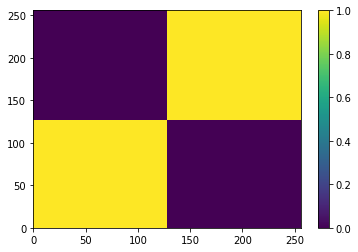

In [78]:
p = plt.pcolormesh(test1[0])
plt.colorbar(p)

In [79]:
test2 = np.kron([[1, 0] * 2, [0, 1] * 2] * 2, np.ones((256, 64, 64)))

In [80]:
test2.shape

(256, 256, 256)

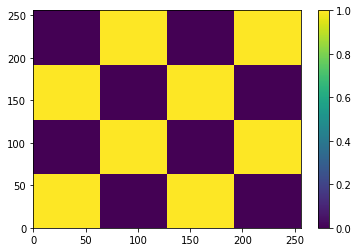

In [81]:
p = plt.pcolormesh(test2[34])
plt.colorbar(p)

In [83]:
test3 = np.kron([[1, 0] * 4, [0, 1] * 4] * 4, np.ones((256, 32, 32)))

In [85]:
test3.shape

(256, 256, 256)

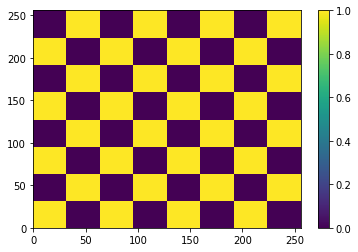

In [86]:
p = plt.pcolormesh(test3[34])
plt.colorbar(p)

In [89]:
test = test1-test2+test3

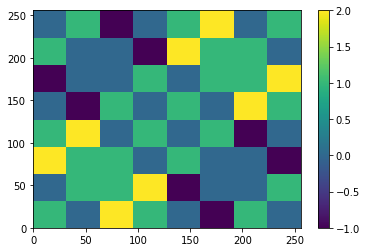

In [90]:
p = plt.pcolormesh(test[34])
plt.colorbar(p)

# Try to seperate layers

In [91]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(test.shape)
wave = 'haar'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 
max_level

8

In [92]:
#dwt_lengths need to be computed for both lat and lon.
dwt_lengths = dwt_length(test[0][0], wave)
dwt_lengths

[256, 128, 64, 32, 16, 8, 4, 2, 1]

In [93]:
index_up = map_back_index(wave,dwt_lengths,max_level)
index_up

[array([  0,   0,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,
          6,   7,   7,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,
         13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  18,  18,  19,
         19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,  25,  25,
         26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,
         32,  33,  33,  34,  34,  35,  35,  36,  36,  37,  37,  38,  38,
         39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,  44,  45,
         45,  46,  46,  47,  47,  48,  48,  49,  49,  50,  50,  51,  51,
         52,  52,  53,  53,  54,  54,  55,  55,  56,  56,  57,  57,  58,
         58,  59,  59,  60,  60,  61,  61,  62,  62,  63,  63,  64,  64,
         65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,  70,  71,
         71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
         78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  83,  84,
         84,  85,  85,  86,  86,  87,  87,  88,  88

In [ ]:
class_sets = []
for i in range(1,max_level+1):
    classes = single_level_class(test, level = i, n_neighbors = 32)
    class_sets.append(classes)

LEVEL: 1
DWT:1.399580478668213
Prep Data:2.6170008182525635
1
Find Params:24.47932267189026
DBSCAN:86.2150285243988
Find Classes:0.15708470344543457
TOTAL: 115.45112419128418

LEVEL: 2


In [75]:
class_sets = map_back_classes(class_sets, index_up, max_level)

IndexError: list index out of range

In [ ]:
plt.figure(-1)
p = plt.pcolormesh(test[0])
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(class_sets[i])
    plt.colorbar(p)